<center><font size = '+2'>QuantumBlack Hackathon</font></center>
<center><font size = '+2'>Pipeline</font></center>
<br>
<center><font size = '+0'>by</font></center>
<br>
<center><font size = '+1'>Yifan WANG, Dayu LIU, Yangfan ZHANGLIN</font></center>
<center><font size = '+1'>Yaqi CHEN, Peizhen CHEN, Xiangying CHEN</font></center>

## Step 1. Data Preprocessing

In [1]:
# a function to create folders
import os
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Folder created: {path}")
    else:
        print(f"Folder already exists: {path}")

In [2]:
# create required folders
dir = os.getcwd()
dir = dir.replace("\\", "/")

create_folder(dir + '/data/train')
create_folder(dir + '/data/train/plume')
create_folder(dir + '/data/train/no_plume')
create_folder(dir + '/data/test')
create_folder(dir + '/data/test/plume')
create_folder(dir + '/data/test/no_plume')

Folder already exists: c:/Wiofin_Projects/QBH/data/train
Folder already exists: c:/Wiofin_Projects/QBH/data/train/plume
Folder already exists: c:/Wiofin_Projects/QBH/data/train/no_plume
Folder already exists: c:/Wiofin_Projects/QBH/data/test
Folder already exists: c:/Wiofin_Projects/QBH/data/test/plume
Folder already exists: c:/Wiofin_Projects/QBH/data/test/no_plume


In [3]:
# get all image names
from glob import glob

plume_list = glob(dir + '/data/images/plume/*.tif')
no_plume_list = glob(dir + '/data/images/no_plume/*.tif')
print(len(plume_list))
print(len(no_plume_list))

214
214


In [4]:
# train-test split
import random as rd
test_plume = rd.sample(plume_list, k = 50)
test_no_plume = rd.sample(no_plume_list, k = 50)
train_plume = list(set(plume_list) - set(test_plume))
train_no_plume = list(set(no_plume_list) - set(test_no_plume))

In [5]:
plume_list[0].split('\\')[-1].split('.')[0]

'20230101_methane_mixing_ratio_id_4928'

In [6]:
# preprocessing and save the images locally
from utils import feature_engineering as fe
import cv2
# process train plumn images
for file in train_plume:
    filename = file.split('\\')[-1].split('.')[0]
    image = fe.preprocess(file)
    cv2.imwrite(dir + f'/data/train/plume/{filename}_0.png', image)
    for i in range (1, 5, 1):
        aug = fe.augment(image, train = i)
        cv2.imwrite(dir + f'/data/train/plume/{filename}_{i}.png', aug)
# process train no plume images
for file in train_no_plume:
    filename = file.split('\\')[-1].split('.')[0]
    image = fe.preprocess(file)
    cv2.imwrite(dir + f'/data/train/no_plume/{filename}_0.png', image)
    for i in range (1, 5, 1):
        aug = fe.augment(image, train = i)
        cv2.imwrite(dir + f'/data/train/no_plume/{filename}_{i}.png', aug)
# process test plume
for file in test_plume:
    filename = file.split('\\')[-1].split('.')[0]
    image = fe.preprocess(file)
    cv2.imwrite(dir + f'/data/test/plume/{filename}.png', image)
# process test no plume
for file in test_no_plume:
    filename = file.split('\\')[-1].split('.')[0]
    image = fe.preprocess(file)
    cv2.imwrite(dir + f'/data/test/no_plume/{filename}.png', image)

We generate 5 images from 1 on the training set using data augmentation.

## Step 2. Model Selection

In [7]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
batch_size = 32
train_dataset = datasets.ImageFolder(dir + '/data/train/', transform = transform)
test_dataset = datasets.ImageFolder(dir + '/data/test/', transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [8]:
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, savename):
    # record the best AUC
    best_auc = 0.0
    best_loss = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc = f"Epoch {epoch + 1}/{num_epochs} - Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_predictions = []
        test_targets = []

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc = f"Epoch {epoch + 1}/{num_epochs} - Evaluation"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_predictions.extend(predicted.cpu().tolist())
                test_targets.extend(labels.cpu().tolist())

        test_loss /= len(test_loader)
        test_accuracy = accuracy_score(test_targets, test_predictions)
        test_f1_score = f1_score(test_targets, test_predictions)
        test_auc = roc_auc_score(test_targets, test_predictions)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
              f"Accuracy: {test_accuracy:.4f} | F1 Score: {test_f1_score:.4f} | AUC: {test_auc:.4f}")

        # Save the model with the best AUC
        if test_auc > best_auc:
            best_auc = test_auc
            best_loss = test_loss
            torch.save(model.state_dict(), dir + f"/models/{savename}.pth")
        elif test_auc == best_auc:
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model.state_dict(), dir + f"/models/{savename}.pth")
        else:
            pass

### AlexNet

94% Average, 95% Saved

In [9]:
model = models.alexnet(pretrained = True)
num_features = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(num_features, 2)

c:\Wiofin_Softwares\Anaconda\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Wiofin_Softwares\Anaconda\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
num_epochs = 30
model.to(device)
train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, 'alexnet')

Epoch 1/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  7.55it/s]


Epoch 1/30 - Train Loss: 0.5525 | Test Loss: 0.4570 | Accuracy: 0.8200 | F1 Score: 0.8000 | AUC: 0.8200


Epoch 2/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.98it/s]


Epoch 2/30 - Train Loss: 0.4220 | Test Loss: 0.5990 | Accuracy: 0.7500 | F1 Score: 0.6914 | AUC: 0.7500


Epoch 3/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 3/30 - Train Loss: 0.2752 | Test Loss: 0.3113 | Accuracy: 0.8800 | F1 Score: 0.8909 | AUC: 0.8800


Epoch 4/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.39it/s]


Epoch 4/30 - Train Loss: 0.2032 | Test Loss: 0.2817 | Accuracy: 0.9000 | F1 Score: 0.8958 | AUC: 0.9000


Epoch 5/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.39it/s]


Epoch 5/30 - Train Loss: 0.1014 | Test Loss: 0.4881 | Accuracy: 0.8800 | F1 Score: 0.8750 | AUC: 0.8800


Epoch 6/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 6/30 - Train Loss: 0.0763 | Test Loss: 0.4428 | Accuracy: 0.8900 | F1 Score: 0.8791 | AUC: 0.8900


Epoch 7/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.09it/s]


Epoch 7/30 - Train Loss: 0.0498 | Test Loss: 1.1135 | Accuracy: 0.8300 | F1 Score: 0.7952 | AUC: 0.8300


Epoch 8/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.12it/s]


Epoch 8/30 - Train Loss: 0.0649 | Test Loss: 0.4900 | Accuracy: 0.8700 | F1 Score: 0.8506 | AUC: 0.8700


Epoch 9/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.12it/s]


Epoch 9/30 - Train Loss: 0.0401 | Test Loss: 0.3909 | Accuracy: 0.9100 | F1 Score: 0.9053 | AUC: 0.9100


Epoch 10/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 10/30 - Train Loss: 0.0294 | Test Loss: 0.6992 | Accuracy: 0.9100 | F1 Score: 0.9032 | AUC: 0.9100


Epoch 11/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 11/30 - Train Loss: 0.0541 | Test Loss: 0.2646 | Accuracy: 0.8700 | F1 Score: 0.8713 | AUC: 0.8700


Epoch 12/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 12/30 - Train Loss: 0.0498 | Test Loss: 1.0770 | Accuracy: 0.8100 | F1 Score: 0.7654 | AUC: 0.8100


Epoch 13/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.12it/s]


Epoch 13/30 - Train Loss: 0.0639 | Test Loss: 0.2060 | Accuracy: 0.9100 | F1 Score: 0.9143 | AUC: 0.9100


Epoch 14/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.85it/s]


Epoch 14/30 - Train Loss: 0.0140 | Test Loss: 0.1772 | Accuracy: 0.9400 | F1 Score: 0.9412 | AUC: 0.9400


Epoch 15/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.85it/s]


Epoch 15/30 - Train Loss: 0.0139 | Test Loss: 0.3015 | Accuracy: 0.9100 | F1 Score: 0.9159 | AUC: 0.9100


Epoch 16/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.51it/s]


Epoch 16/30 - Train Loss: 0.0125 | Test Loss: 0.3742 | Accuracy: 0.8900 | F1 Score: 0.8972 | AUC: 0.8900


Epoch 17/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.59it/s]


Epoch 17/30 - Train Loss: 0.0115 | Test Loss: 0.4417 | Accuracy: 0.9100 | F1 Score: 0.9032 | AUC: 0.9100


Epoch 18/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.12it/s]


Epoch 18/30 - Train Loss: 0.0233 | Test Loss: 0.4926 | Accuracy: 0.8600 | F1 Score: 0.8571 | AUC: 0.8600


Epoch 19/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.72it/s]


Epoch 19/30 - Train Loss: 0.0129 | Test Loss: 0.6713 | Accuracy: 0.8500 | F1 Score: 0.8315 | AUC: 0.8500


Epoch 20/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.72it/s]


Epoch 20/30 - Train Loss: 0.0056 | Test Loss: 0.5508 | Accuracy: 0.8900 | F1 Score: 0.8842 | AUC: 0.8900


Epoch 21/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.85it/s]


Epoch 21/30 - Train Loss: 0.0027 | Test Loss: 0.3002 | Accuracy: 0.8900 | F1 Score: 0.8911 | AUC: 0.8900


Epoch 22/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.98it/s]


Epoch 22/30 - Train Loss: 0.0026 | Test Loss: 0.3018 | Accuracy: 0.9200 | F1 Score: 0.9200 | AUC: 0.9200


Epoch 23/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.09it/s]


Epoch 23/30 - Train Loss: 0.0046 | Test Loss: 0.4093 | Accuracy: 0.8800 | F1 Score: 0.8776 | AUC: 0.8800


Epoch 24/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.91it/s]


Epoch 24/30 - Train Loss: 0.0027 | Test Loss: 1.1392 | Accuracy: 0.8600 | F1 Score: 0.8409 | AUC: 0.8600


Epoch 25/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.05it/s]


Epoch 25/30 - Train Loss: 0.0670 | Test Loss: 0.3842 | Accuracy: 0.8600 | F1 Score: 0.8478 | AUC: 0.8600


Epoch 26/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 22.59it/s]


Epoch 26/30 - Train Loss: 0.0599 | Test Loss: 0.2755 | Accuracy: 0.9200 | F1 Score: 0.9149 | AUC: 0.9200


Epoch 27/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.63it/s]


Epoch 27/30 - Train Loss: 0.0488 | Test Loss: 0.4353 | Accuracy: 0.8400 | F1 Score: 0.8596 | AUC: 0.8400


Epoch 28/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.95it/s]


Epoch 28/30 - Train Loss: 0.0206 | Test Loss: 0.2271 | Accuracy: 0.9000 | F1 Score: 0.8958 | AUC: 0.9000


Epoch 29/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.85it/s]


Epoch 29/30 - Train Loss: 0.0503 | Test Loss: 0.7342 | Accuracy: 0.8800 | F1 Score: 0.8667 | AUC: 0.8800


Epoch 30/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 23.39it/s]

Epoch 30/30 - Train Loss: 0.0339 | Test Loss: 0.3527 | Accuracy: 0.9000 | F1 Score: 0.8980 | AUC: 0.9000


### ResNet34

97% Average, 98% saved

In [12]:
model = models.resnet34(weights = 'DEFAULT')
model.fc=nn.Linear(in_features = 512, out_features = 2, bias = True)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
num_epochs = 30
model.to(device)
train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, 'resnet34')

Epoch 1/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 13.42it/s]


Epoch 1/30 - Train Loss: 0.4570 | Test Loss: 0.2593 | Accuracy: 0.8900 | F1 Score: 0.8889 | AUC: 0.8900


Epoch 2/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.60it/s]


Epoch 2/30 - Train Loss: 0.1567 | Test Loss: 0.3125 | Accuracy: 0.8800 | F1 Score: 0.8667 | AUC: 0.8800


Epoch 3/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.76it/s]


Epoch 3/30 - Train Loss: 0.1077 | Test Loss: 0.5612 | Accuracy: 0.8700 | F1 Score: 0.8506 | AUC: 0.8700


Epoch 4/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 13.98it/s]


Epoch 4/30 - Train Loss: 0.0522 | Test Loss: 0.3662 | Accuracy: 0.9100 | F1 Score: 0.9032 | AUC: 0.9100


Epoch 5/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.92it/s]


Epoch 5/30 - Train Loss: 0.0437 | Test Loss: 0.2436 | Accuracy: 0.9300 | F1 Score: 0.9247 | AUC: 0.9300


Epoch 6/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.33it/s]


Epoch 6/30 - Train Loss: 0.0466 | Test Loss: 0.4511 | Accuracy: 0.9000 | F1 Score: 0.8936 | AUC: 0.9000


Epoch 7/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.08it/s]


Epoch 7/30 - Train Loss: 0.0542 | Test Loss: 0.3112 | Accuracy: 0.8900 | F1 Score: 0.8817 | AUC: 0.8900


Epoch 8/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.18it/s]


Epoch 8/30 - Train Loss: 0.0204 | Test Loss: 0.1837 | Accuracy: 0.9200 | F1 Score: 0.9216 | AUC: 0.9200


Epoch 9/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 15.47it/s]


Epoch 9/30 - Train Loss: 0.0146 | Test Loss: 0.1714 | Accuracy: 0.9000 | F1 Score: 0.8958 | AUC: 0.9000


Epoch 10/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 15.32it/s]


Epoch 10/30 - Train Loss: 0.0260 | Test Loss: 0.8461 | Accuracy: 0.8800 | F1 Score: 0.8667 | AUC: 0.8800


Epoch 11/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.70it/s]


Epoch 11/30 - Train Loss: 0.0527 | Test Loss: 0.5814 | Accuracy: 0.7800 | F1 Score: 0.8197 | AUC: 0.7800


Epoch 12/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 12/30 - Train Loss: 0.1366 | Test Loss: 0.7319 | Accuracy: 0.8400 | F1 Score: 0.8182 | AUC: 0.8400


Epoch 13/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 13.89it/s]


Epoch 13/30 - Train Loss: 0.0806 | Test Loss: 0.4427 | Accuracy: 0.9000 | F1 Score: 0.8889 | AUC: 0.9000


Epoch 14/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.23it/s]


Epoch 14/30 - Train Loss: 0.0643 | Test Loss: 0.1408 | Accuracy: 0.9300 | F1 Score: 0.9293 | AUC: 0.9300


Epoch 15/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.33it/s]


Epoch 15/30 - Train Loss: 0.0154 | Test Loss: 0.1697 | Accuracy: 0.9200 | F1 Score: 0.9167 | AUC: 0.9200


Epoch 16/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 16/30 - Train Loss: 0.0101 | Test Loss: 0.1426 | Accuracy: 0.9400 | F1 Score: 0.9400 | AUC: 0.9400


Epoch 17/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 13.33it/s]


Epoch 17/30 - Train Loss: 0.0056 | Test Loss: 0.2411 | Accuracy: 0.9100 | F1 Score: 0.9032 | AUC: 0.9100


Epoch 18/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 18/30 - Train Loss: 0.0034 | Test Loss: 0.1215 | Accuracy: 0.9300 | F1 Score: 0.9293 | AUC: 0.9300


Epoch 19/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 19/30 - Train Loss: 0.0045 | Test Loss: 0.1279 | Accuracy: 0.9300 | F1 Score: 0.9278 | AUC: 0.9300


Epoch 20/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.18it/s]


Epoch 20/30 - Train Loss: 0.0035 | Test Loss: 0.3251 | Accuracy: 0.9000 | F1 Score: 0.8889 | AUC: 0.9000


Epoch 21/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 13.93it/s]


Epoch 21/30 - Train Loss: 0.0053 | Test Loss: 0.1260 | Accuracy: 0.9300 | F1 Score: 0.9293 | AUC: 0.9300


Epoch 22/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.08it/s]


Epoch 22/30 - Train Loss: 0.0050 | Test Loss: 0.1358 | Accuracy: 0.9300 | F1 Score: 0.9278 | AUC: 0.9300


Epoch 23/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.08it/s]


Epoch 23/30 - Train Loss: 0.0234 | Test Loss: 0.1298 | Accuracy: 0.9200 | F1 Score: 0.9245 | AUC: 0.9200


Epoch 24/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 13.84it/s]


Epoch 24/30 - Train Loss: 0.1331 | Test Loss: 0.7395 | Accuracy: 0.8400 | F1 Score: 0.8140 | AUC: 0.8400


Epoch 25/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.28it/s]


Epoch 25/30 - Train Loss: 0.0526 | Test Loss: 0.2914 | Accuracy: 0.9200 | F1 Score: 0.9149 | AUC: 0.9200


Epoch 26/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 13.63it/s]


Epoch 26/30 - Train Loss: 0.0126 | Test Loss: 0.1975 | Accuracy: 0.9400 | F1 Score: 0.9388 | AUC: 0.9400


Epoch 27/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 13.91it/s]


Epoch 27/30 - Train Loss: 0.0230 | Test Loss: 0.2369 | Accuracy: 0.9400 | F1 Score: 0.9388 | AUC: 0.9400


Epoch 28/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 28/30 - Train Loss: 0.0139 | Test Loss: 0.1308 | Accuracy: 0.9600 | F1 Score: 0.9600 | AUC: 0.9600


Epoch 29/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.13it/s]


Epoch 29/30 - Train Loss: 0.0215 | Test Loss: 0.3766 | Accuracy: 0.9300 | F1 Score: 0.9263 | AUC: 0.9300


Epoch 30/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.18it/s]


Epoch 30/30 - Train Loss: 0.0082 | Test Loss: 0.1199 | Accuracy: 0.9700 | F1 Score: 0.9709 | AUC: 0.9700


### ResNet50

96% Average, 97% Saved

In [14]:
model = models.resnext50_32x4d(weights = 'DEFAULT')
model.fc=nn.Linear(in_features = 2048, out_features = 2, bias = True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to C:\Users\wiofi/.cache\torch\hub\checkpoints\resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:04<00:00, 24.7MB/s]


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
num_epochs = 30
model.to(device)
train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, 'resnet50')

Epoch 1/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.91it/s]


Epoch 1/30 - Train Loss: 0.0352 | Test Loss: 0.6736 | Accuracy: 0.8500 | F1 Score: 0.8276 | AUC: 0.8500


Epoch 2/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.09it/s]


Epoch 2/30 - Train Loss: 0.0169 | Test Loss: 0.2483 | Accuracy: 0.9100 | F1 Score: 0.9109 | AUC: 0.9100


Epoch 3/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.28it/s]


Epoch 3/30 - Train Loss: 0.0122 | Test Loss: 0.3732 | Accuracy: 0.8800 | F1 Score: 0.8800 | AUC: 0.8800


Epoch 4/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


Epoch 4/30 - Train Loss: 0.0176 | Test Loss: 0.5565 | Accuracy: 0.9000 | F1 Score: 0.9000 | AUC: 0.9000


Epoch 5/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]


Epoch 5/30 - Train Loss: 0.0054 | Test Loss: 0.4881 | Accuracy: 0.9100 | F1 Score: 0.9091 | AUC: 0.9100


Epoch 6/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]


Epoch 6/30 - Train Loss: 0.0045 | Test Loss: 0.4894 | Accuracy: 0.8700 | F1 Score: 0.8713 | AUC: 0.8700


Epoch 7/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.80it/s]


Epoch 7/30 - Train Loss: 0.0194 | Test Loss: 0.3739 | Accuracy: 0.8400 | F1 Score: 0.8571 | AUC: 0.8400


Epoch 8/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.88it/s]


Epoch 8/30 - Train Loss: 0.0126 | Test Loss: 0.3353 | Accuracy: 0.8700 | F1 Score: 0.8807 | AUC: 0.8700


Epoch 9/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.03it/s]


Epoch 9/30 - Train Loss: 0.0208 | Test Loss: 0.7012 | Accuracy: 0.8200 | F1 Score: 0.7955 | AUC: 0.8200


Epoch 10/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.11it/s]


Epoch 10/30 - Train Loss: 0.0072 | Test Loss: 0.2531 | Accuracy: 0.9000 | F1 Score: 0.8980 | AUC: 0.9000


Epoch 11/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.69it/s]


Epoch 11/30 - Train Loss: 0.0084 | Test Loss: 0.4976 | Accuracy: 0.8500 | F1 Score: 0.8571 | AUC: 0.8500


Epoch 12/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.81it/s]


Epoch 12/30 - Train Loss: 0.0088 | Test Loss: 0.3186 | Accuracy: 0.8700 | F1 Score: 0.8785 | AUC: 0.8700


Epoch 13/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.85it/s]


Epoch 13/30 - Train Loss: 0.0382 | Test Loss: 0.4249 | Accuracy: 0.9000 | F1 Score: 0.8980 | AUC: 0.9000


Epoch 14/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.05it/s]


Epoch 14/30 - Train Loss: 0.0199 | Test Loss: 0.9229 | Accuracy: 0.8500 | F1 Score: 0.8315 | AUC: 0.8500


Epoch 15/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.73it/s]


Epoch 15/30 - Train Loss: 0.0076 | Test Loss: 0.5695 | Accuracy: 0.8600 | F1 Score: 0.8444 | AUC: 0.8600


Epoch 16/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.91it/s]


Epoch 16/30 - Train Loss: 0.0077 | Test Loss: 0.5473 | Accuracy: 0.8400 | F1 Score: 0.8298 | AUC: 0.8400


Epoch 17/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.77it/s]


Epoch 17/30 - Train Loss: 0.0028 | Test Loss: 0.7053 | Accuracy: 0.8500 | F1 Score: 0.8387 | AUC: 0.8500


Epoch 18/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.95it/s]


Epoch 18/30 - Train Loss: 0.0028 | Test Loss: 0.9470 | Accuracy: 0.8600 | F1 Score: 0.8444 | AUC: 0.8600


Epoch 19/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.05it/s]


Epoch 19/30 - Train Loss: 0.0057 | Test Loss: 0.4284 | Accuracy: 0.8700 | F1 Score: 0.8785 | AUC: 0.8700


Epoch 20/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.64it/s]


Epoch 20/30 - Train Loss: 0.0346 | Test Loss: 0.6867 | Accuracy: 0.8800 | F1 Score: 0.8696 | AUC: 0.8800


Epoch 21/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.79it/s]


Epoch 21/30 - Train Loss: 0.0737 | Test Loss: 0.4706 | Accuracy: 0.8700 | F1 Score: 0.8713 | AUC: 0.8700


Epoch 22/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.01it/s]


Epoch 22/30 - Train Loss: 0.0207 | Test Loss: 0.6851 | Accuracy: 0.8400 | F1 Score: 0.8182 | AUC: 0.8400


Epoch 23/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.95it/s]


Epoch 23/30 - Train Loss: 0.0123 | Test Loss: 0.4542 | Accuracy: 0.8400 | F1 Score: 0.8367 | AUC: 0.8400


Epoch 24/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.06it/s]


Epoch 24/30 - Train Loss: 0.0121 | Test Loss: 0.6399 | Accuracy: 0.8500 | F1 Score: 0.8352 | AUC: 0.8500


Epoch 25/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.77it/s]


Epoch 25/30 - Train Loss: 0.0413 | Test Loss: 0.5205 | Accuracy: 0.8600 | F1 Score: 0.8750 | AUC: 0.8600


Epoch 26/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.79it/s]


Epoch 26/30 - Train Loss: 0.0622 | Test Loss: 0.3953 | Accuracy: 0.8800 | F1 Score: 0.8909 | AUC: 0.8800


Epoch 27/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.55it/s]


Epoch 27/30 - Train Loss: 0.0235 | Test Loss: 0.4483 | Accuracy: 0.8500 | F1 Score: 0.8421 | AUC: 0.8500


Epoch 28/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.91it/s]


Epoch 28/30 - Train Loss: 0.0320 | Test Loss: 0.3386 | Accuracy: 0.8900 | F1 Score: 0.8889 | AUC: 0.8900


Epoch 29/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.75it/s]


Epoch 29/30 - Train Loss: 0.0295 | Test Loss: 0.3237 | Accuracy: 0.9200 | F1 Score: 0.9149 | AUC: 0.9200


Epoch 30/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.39it/s]


Epoch 30/30 - Train Loss: 0.0119 | Test Loss: 0.2735 | Accuracy: 0.9600 | F1 Score: 0.9592 | AUC: 0.9600


### ResNet18

97% Average, 98% Saved

In [20]:
model = models.resnet18(pretrained = True)
model.fc = nn.Linear(in_features = 512, out_features = 2, bias = True)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
num_epochs = 30
model.to(device)
train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, 'resnet18')

Epoch 1/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.85it/s]


Epoch 1/30 - Train Loss: 0.4919 | Test Loss: 0.9696 | Accuracy: 0.6700 | F1 Score: 0.5075 | AUC: 0.6700


Epoch 2/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.46it/s]


Epoch 2/30 - Train Loss: 0.1485 | Test Loss: 0.5232 | Accuracy: 0.8400 | F1 Score: 0.8140 | AUC: 0.8400


Epoch 3/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.93it/s]


Epoch 3/30 - Train Loss: 0.0475 | Test Loss: 0.3407 | Accuracy: 0.9100 | F1 Score: 0.9072 | AUC: 0.9100


Epoch 4/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.62it/s]


Epoch 4/30 - Train Loss: 0.0243 | Test Loss: 0.3852 | Accuracy: 0.9000 | F1 Score: 0.8936 | AUC: 0.9000


Epoch 5/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s]


Epoch 5/30 - Train Loss: 0.0317 | Test Loss: 0.2892 | Accuracy: 0.8600 | F1 Score: 0.8750 | AUC: 0.8600


Epoch 6/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 16.13it/s]


Epoch 6/30 - Train Loss: 0.0520 | Test Loss: 0.5486 | Accuracy: 0.8700 | F1 Score: 0.8713 | AUC: 0.8700


Epoch 7/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.24it/s]


Epoch 7/30 - Train Loss: 0.0263 | Test Loss: 0.4811 | Accuracy: 0.8900 | F1 Score: 0.8791 | AUC: 0.8900


Epoch 8/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.09it/s]


Epoch 8/30 - Train Loss: 0.0092 | Test Loss: 0.6136 | Accuracy: 0.9000 | F1 Score: 0.8913 | AUC: 0.9000


Epoch 9/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.54it/s]


Epoch 9/30 - Train Loss: 0.0087 | Test Loss: 0.3571 | Accuracy: 0.9100 | F1 Score: 0.9091 | AUC: 0.9100


Epoch 10/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 14.49it/s]


Epoch 10/30 - Train Loss: 0.0148 | Test Loss: 0.5354 | Accuracy: 0.8500 | F1 Score: 0.8387 | AUC: 0.8500


Epoch 11/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.93it/s]


Epoch 11/30 - Train Loss: 0.0078 | Test Loss: 0.3758 | Accuracy: 0.8900 | F1 Score: 0.8972 | AUC: 0.8900


Epoch 12/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.77it/s]


Epoch 12/30 - Train Loss: 0.0076 | Test Loss: 0.3662 | Accuracy: 0.9100 | F1 Score: 0.9032 | AUC: 0.9100


Epoch 13/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.62it/s]


Epoch 13/30 - Train Loss: 0.0229 | Test Loss: 0.2731 | Accuracy: 0.9100 | F1 Score: 0.9126 | AUC: 0.9100


Epoch 14/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.85it/s]


Epoch 14/30 - Train Loss: 0.0673 | Test Loss: 0.4965 | Accuracy: 0.8400 | F1 Score: 0.8571 | AUC: 0.8400


Epoch 15/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.93it/s]


Epoch 15/30 - Train Loss: 0.0530 | Test Loss: 0.2838 | Accuracy: 0.8900 | F1 Score: 0.8952 | AUC: 0.8900


Epoch 16/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s]


Epoch 16/30 - Train Loss: 0.0374 | Test Loss: 0.2481 | Accuracy: 0.9200 | F1 Score: 0.9184 | AUC: 0.9200


Epoch 17/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.85it/s]


Epoch 17/30 - Train Loss: 0.0453 | Test Loss: 0.5988 | Accuracy: 0.8700 | F1 Score: 0.8602 | AUC: 0.8700


Epoch 18/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.70it/s]


Epoch 18/30 - Train Loss: 0.0136 | Test Loss: 0.1954 | Accuracy: 0.9400 | F1 Score: 0.9362 | AUC: 0.9400


Epoch 19/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 16.13it/s]


Epoch 19/30 - Train Loss: 0.0415 | Test Loss: 0.2541 | Accuracy: 0.9000 | F1 Score: 0.8913 | AUC: 0.9000


Epoch 20/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.93it/s]


Epoch 20/30 - Train Loss: 0.0852 | Test Loss: 0.4608 | Accuracy: 0.8900 | F1 Score: 0.8817 | AUC: 0.8900


Epoch 21/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s]


Epoch 21/30 - Train Loss: 0.0211 | Test Loss: 0.1655 | Accuracy: 0.8900 | F1 Score: 0.8952 | AUC: 0.8900


Epoch 22/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.01it/s]


Epoch 22/30 - Train Loss: 0.0055 | Test Loss: 0.1467 | Accuracy: 0.9500 | F1 Score: 0.9505 | AUC: 0.9500


Epoch 23/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.46it/s]


Epoch 23/30 - Train Loss: 0.0065 | Test Loss: 0.1670 | Accuracy: 0.9400 | F1 Score: 0.9388 | AUC: 0.9400


Epoch 24/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.31it/s]


Epoch 24/30 - Train Loss: 0.0028 | Test Loss: 0.1540 | Accuracy: 0.9600 | F1 Score: 0.9600 | AUC: 0.9600


Epoch 25/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s]


Epoch 25/30 - Train Loss: 0.0049 | Test Loss: 0.1341 | Accuracy: 0.9700 | F1 Score: 0.9703 | AUC: 0.9700


Epoch 26/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.10it/s]


Epoch 26/30 - Train Loss: 0.0027 | Test Loss: 0.2079 | Accuracy: 0.9100 | F1 Score: 0.9053 | AUC: 0.9100


Epoch 27/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s]


Epoch 27/30 - Train Loss: 0.0026 | Test Loss: 0.1493 | Accuracy: 0.9500 | F1 Score: 0.9495 | AUC: 0.9500


Epoch 28/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s]


Epoch 28/30 - Train Loss: 0.0047 | Test Loss: 0.1537 | Accuracy: 0.9500 | F1 Score: 0.9505 | AUC: 0.9500


Epoch 29/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.77it/s]


Epoch 29/30 - Train Loss: 0.0028 | Test Loss: 0.3590 | Accuracy: 0.8900 | F1 Score: 0.8817 | AUC: 0.8900


Epoch 30/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.85it/s]

Epoch 30/30 - Train Loss: 0.0022 | Test Loss: 0.1528 | Accuracy: 0.9500 | F1 Score: 0.9495 | AUC: 0.9500


## Mobilenet v3

94% Average, 95% Saved

In [27]:
model = models.mobilenet_v3_large(weights = 'DEFAULT')
model.classifier[3] = nn.Linear(in_features = 1280, out_features = 2, bias = True)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
num_epochs = 30
model.to(device)
train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, 'mobilenet')

Epoch 1/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s]


Epoch 1/30 - Train Loss: 0.5356 | Test Loss: 0.6180 | Accuracy: 0.7200 | F1 Score: 0.6585 | AUC: 0.7200


Epoch 2/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s]


Epoch 2/30 - Train Loss: 0.2802 | Test Loss: 0.5193 | Accuracy: 0.8100 | F1 Score: 0.7912 | AUC: 0.8100


Epoch 3/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.62it/s]


Epoch 3/30 - Train Loss: 0.1335 | Test Loss: 0.5345 | Accuracy: 0.6600 | F1 Score: 0.7463 | AUC: 0.6600


Epoch 4/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.85it/s]


Epoch 4/30 - Train Loss: 0.0672 | Test Loss: 0.4160 | Accuracy: 0.8300 | F1 Score: 0.8440 | AUC: 0.8300


Epoch 5/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.34it/s]


Epoch 5/30 - Train Loss: 0.0521 | Test Loss: 0.4821 | Accuracy: 0.6700 | F1 Score: 0.7519 | AUC: 0.6700


Epoch 6/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.62it/s]


Epoch 6/30 - Train Loss: 0.0302 | Test Loss: 0.4777 | Accuracy: 0.7200 | F1 Score: 0.7813 | AUC: 0.7200


Epoch 7/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.51it/s]


Epoch 7/30 - Train Loss: 0.0273 | Test Loss: 0.4668 | Accuracy: 0.7100 | F1 Score: 0.7752 | AUC: 0.7100


Epoch 8/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s]


Epoch 8/30 - Train Loss: 0.0207 | Test Loss: 0.3638 | Accuracy: 0.7800 | F1 Score: 0.8197 | AUC: 0.7800


Epoch 9/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.09it/s]


Epoch 9/30 - Train Loss: 0.0122 | Test Loss: 0.3524 | Accuracy: 0.7700 | F1 Score: 0.8067 | AUC: 0.7700


Epoch 10/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.43it/s]


Epoch 10/30 - Train Loss: 0.0121 | Test Loss: 0.3109 | Accuracy: 0.8300 | F1 Score: 0.8350 | AUC: 0.8300


Epoch 11/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.01it/s]


Epoch 11/30 - Train Loss: 0.0136 | Test Loss: 0.3700 | Accuracy: 0.8500 | F1 Score: 0.8454 | AUC: 0.8500


Epoch 12/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.26it/s]


Epoch 12/30 - Train Loss: 0.0192 | Test Loss: 0.2939 | Accuracy: 0.8700 | F1 Score: 0.8660 | AUC: 0.8700


Epoch 13/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.73it/s]


Epoch 13/30 - Train Loss: 0.0078 | Test Loss: 0.2796 | Accuracy: 0.8800 | F1 Score: 0.8909 | AUC: 0.8800


Epoch 14/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.69it/s]


Epoch 14/30 - Train Loss: 0.0100 | Test Loss: 0.2633 | Accuracy: 0.8700 | F1 Score: 0.8807 | AUC: 0.8700


Epoch 15/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.01it/s]


Epoch 15/30 - Train Loss: 0.0179 | Test Loss: 0.2263 | Accuracy: 0.8600 | F1 Score: 0.8750 | AUC: 0.8600


Epoch 16/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.26it/s]


Epoch 16/30 - Train Loss: 0.0255 | Test Loss: 0.1688 | Accuracy: 0.9100 | F1 Score: 0.9109 | AUC: 0.9100


Epoch 17/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.69it/s]


Epoch 17/30 - Train Loss: 0.0117 | Test Loss: 0.2533 | Accuracy: 0.9000 | F1 Score: 0.9057 | AUC: 0.9000


Epoch 18/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s]


Epoch 18/30 - Train Loss: 0.0051 | Test Loss: 0.3738 | Accuracy: 0.8800 | F1 Score: 0.8824 | AUC: 0.8800


Epoch 19/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s]


Epoch 19/30 - Train Loss: 0.0047 | Test Loss: 0.2835 | Accuracy: 0.8900 | F1 Score: 0.8932 | AUC: 0.8900


Epoch 20/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s]


Epoch 20/30 - Train Loss: 0.0032 | Test Loss: 0.2737 | Accuracy: 0.9200 | F1 Score: 0.9200 | AUC: 0.9200


Epoch 21/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.01it/s]


Epoch 21/30 - Train Loss: 0.0021 | Test Loss: 0.2783 | Accuracy: 0.9200 | F1 Score: 0.9200 | AUC: 0.9200


Epoch 22/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 17.93it/s]


Epoch 22/30 - Train Loss: 0.0294 | Test Loss: 0.2612 | Accuracy: 0.9300 | F1 Score: 0.9307 | AUC: 0.9300


Epoch 23/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.34it/s]


Epoch 23/30 - Train Loss: 0.0514 | Test Loss: 0.3185 | Accuracy: 0.8700 | F1 Score: 0.8738 | AUC: 0.8700


Epoch 24/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.01it/s]


Epoch 24/30 - Train Loss: 0.0109 | Test Loss: 0.2455 | Accuracy: 0.9100 | F1 Score: 0.9126 | AUC: 0.9100


Epoch 25/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s]


Epoch 25/30 - Train Loss: 0.0040 | Test Loss: 0.2437 | Accuracy: 0.9400 | F1 Score: 0.9400 | AUC: 0.9400


Epoch 26/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s]


Epoch 26/30 - Train Loss: 0.0041 | Test Loss: 0.2972 | Accuracy: 0.9200 | F1 Score: 0.9184 | AUC: 0.9200


Epoch 27/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.34it/s]


Epoch 27/30 - Train Loss: 0.0021 | Test Loss: 0.2977 | Accuracy: 0.9300 | F1 Score: 0.9293 | AUC: 0.9300


Epoch 28/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s]


Epoch 28/30 - Train Loss: 0.0102 | Test Loss: 0.2977 | Accuracy: 0.9200 | F1 Score: 0.9167 | AUC: 0.9200


Epoch 29/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.01it/s]


Epoch 29/30 - Train Loss: 0.0053 | Test Loss: 0.2480 | Accuracy: 0.9000 | F1 Score: 0.9000 | AUC: 0.9000


Epoch 30/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 18.51it/s]

Epoch 30/30 - Train Loss: 0.0070 | Test Loss: 0.2826 | Accuracy: 0.9000 | F1 Score: 0.9000 | AUC: 0.9000


### ShuffleNet v2

89%, abandoned

In [31]:
model = models.shufflenet_v2_x1_0(weights = 'DEFAULT')
model.fc = nn.Linear(in_features = 1024, out_features = 2, bias = True)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
num_epochs = 30
model.to(device)
train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, 'shufflenet')

Epoch 1/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.97it/s]


Epoch 1/30 - Train Loss: 0.6769 | Test Loss: 0.6392 | Accuracy: 0.7700 | F1 Score: 0.8034 | AUC: 0.7700


Epoch 2/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.27it/s]


Epoch 2/30 - Train Loss: 0.5922 | Test Loss: 0.4845 | Accuracy: 0.8500 | F1 Score: 0.8598 | AUC: 0.8500


Epoch 3/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.50it/s]


Epoch 3/30 - Train Loss: 0.4882 | Test Loss: 0.4163 | Accuracy: 0.8500 | F1 Score: 0.8571 | AUC: 0.8500


Epoch 4/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.36it/s]


Epoch 4/30 - Train Loss: 0.3899 | Test Loss: 0.4275 | Accuracy: 0.8800 | F1 Score: 0.8800 | AUC: 0.8800


Epoch 5/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.85it/s]


Epoch 5/30 - Train Loss: 0.2941 | Test Loss: 0.4381 | Accuracy: 0.8700 | F1 Score: 0.8660 | AUC: 0.8700


Epoch 6/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.73it/s]


Epoch 6/30 - Train Loss: 0.2237 | Test Loss: 0.4233 | Accuracy: 0.8700 | F1 Score: 0.8738 | AUC: 0.8700


Epoch 7/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.16it/s]


Epoch 7/30 - Train Loss: 0.1512 | Test Loss: 0.4963 | Accuracy: 0.8400 | F1 Score: 0.8333 | AUC: 0.8400


Epoch 8/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.16it/s]


Epoch 8/30 - Train Loss: 0.1112 | Test Loss: 0.4053 | Accuracy: 0.8500 | F1 Score: 0.8544 | AUC: 0.8500


Epoch 9/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.16it/s]


Epoch 9/30 - Train Loss: 0.0768 | Test Loss: 0.4391 | Accuracy: 0.8900 | F1 Score: 0.8889 | AUC: 0.8900


Epoch 10/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.83it/s]


Epoch 10/30 - Train Loss: 0.0537 | Test Loss: 0.5302 | Accuracy: 0.8600 | F1 Score: 0.8571 | AUC: 0.8600


Epoch 11/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.72it/s]


Epoch 11/30 - Train Loss: 0.0444 | Test Loss: 0.5489 | Accuracy: 0.8900 | F1 Score: 0.8866 | AUC: 0.8900


Epoch 12/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.72it/s]


Epoch 12/30 - Train Loss: 0.0496 | Test Loss: 0.4958 | Accuracy: 0.8600 | F1 Score: 0.8627 | AUC: 0.8600


Epoch 13/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 19.80it/s]


Epoch 13/30 - Train Loss: 0.0357 | Test Loss: 0.5447 | Accuracy: 0.8800 | F1 Score: 0.8750 | AUC: 0.8800


Epoch 14/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.72it/s]


Epoch 14/30 - Train Loss: 0.0199 | Test Loss: 0.6194 | Accuracy: 0.8600 | F1 Score: 0.8571 | AUC: 0.8600


Epoch 15/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.83it/s]


Epoch 15/30 - Train Loss: 0.0192 | Test Loss: 0.6005 | Accuracy: 0.8800 | F1 Score: 0.8776 | AUC: 0.8800


Epoch 16/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.05it/s]


Epoch 16/30 - Train Loss: 0.0716 | Test Loss: 0.4437 | Accuracy: 0.8800 | F1 Score: 0.8846 | AUC: 0.8800


Epoch 17/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.72it/s]


Epoch 17/30 - Train Loss: 0.0408 | Test Loss: 0.5650 | Accuracy: 0.8900 | F1 Score: 0.8889 | AUC: 0.8900


Epoch 18/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.62it/s]


Epoch 18/30 - Train Loss: 0.0384 | Test Loss: 0.4776 | Accuracy: 0.8900 | F1 Score: 0.8911 | AUC: 0.8900


Epoch 19/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.94it/s]


Epoch 19/30 - Train Loss: 0.0257 | Test Loss: 0.5058 | Accuracy: 0.8900 | F1 Score: 0.8866 | AUC: 0.8900


Epoch 20/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.61it/s]


Epoch 20/30 - Train Loss: 0.0241 | Test Loss: 0.6750 | Accuracy: 0.8600 | F1 Score: 0.8571 | AUC: 0.8600


Epoch 21/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.50it/s]


Epoch 21/30 - Train Loss: 0.0233 | Test Loss: 0.6785 | Accuracy: 0.8500 | F1 Score: 0.8454 | AUC: 0.8500


Epoch 22/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.62it/s]


Epoch 22/30 - Train Loss: 0.0169 | Test Loss: 0.6830 | Accuracy: 0.8700 | F1 Score: 0.8687 | AUC: 0.8700


Epoch 23/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.72it/s]


Epoch 23/30 - Train Loss: 0.0146 | Test Loss: 0.6478 | Accuracy: 0.8600 | F1 Score: 0.8571 | AUC: 0.8600


Epoch 24/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.94it/s]


Epoch 24/30 - Train Loss: 0.0083 | Test Loss: 0.7277 | Accuracy: 0.8600 | F1 Score: 0.8571 | AUC: 0.8600


Epoch 25/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.61it/s]


Epoch 25/30 - Train Loss: 0.0086 | Test Loss: 0.6509 | Accuracy: 0.8800 | F1 Score: 0.8750 | AUC: 0.8800


Epoch 26/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.83it/s]


Epoch 26/30 - Train Loss: 0.0133 | Test Loss: 0.8459 | Accuracy: 0.8800 | F1 Score: 0.8723 | AUC: 0.8800


Epoch 27/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.40it/s]


Epoch 27/30 - Train Loss: 0.0116 | Test Loss: 0.8685 | Accuracy: 0.8700 | F1 Score: 0.8602 | AUC: 0.8700


Epoch 28/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.50it/s]


Epoch 28/30 - Train Loss: 0.0074 | Test Loss: 0.7249 | Accuracy: 0.8500 | F1 Score: 0.8485 | AUC: 0.8500


Epoch 29/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 21.27it/s]


Epoch 29/30 - Train Loss: 0.0066 | Test Loss: 0.8820 | Accuracy: 0.8500 | F1 Score: 0.8421 | AUC: 0.8500


Epoch 30/30 - Evaluation: 100%|██████████| 4/4 [00:00<00:00, 20.40it/s]

Epoch 30/30 - Train Loss: 0.0065 | Test Loss: 0.8497 | Accuracy: 0.8500 | F1 Score: 0.8421 | AUC: 0.8500


## Prediction Test

In [4]:
from utils import feature_engineering as fe
from models import predict

### Test on one image

In [7]:
file = plume_list[0]
image = fe.preprocess(file)
res_label = predict.predict(image, dir = dir, model_choice = 'resnet34', prob = False)
res_prob = predict.predict(image, dir = dir, model_choice = 'resnet34', prob = True)
print(res_label)
print(res_prob)

1
[6.448290e-05 9.999355e-01]


In [9]:
files = [plume_list[0]]
images = [fe.preprocess(file) for file in files]
res_label = predict.predict(images, dir = dir, model_choice = 'resnet34', prob = False)
res_prob = predict.predict(images, dir = dir, model_choice = 'resnet34', prob = True)
print(res_label)
print(res_prob)

[1]
[array([6.448290e-05, 9.999355e-01], dtype=float32)]


### Test on all models

In [10]:
file = plume_list[0]
image = fe.preprocess(file)
res_label = predict.predict(image, dir = dir, model_choice = 'resnet18', prob = False)
res_prob = predict.predict(image, dir = dir, model_choice = 'resnet18', prob = True)
print(res_label)
print(res_prob)

1
[1.0686435e-05 9.9998927e-01]


In [11]:
file = plume_list[0]
image = fe.preprocess(file)
res_label = predict.predict(image, dir = dir, model_choice = 'resnet50', prob = False)
res_prob = predict.predict(image, dir = dir, model_choice = 'resnet50', prob = True)
print(res_label)
print(res_prob)

1
[1.0815814e-08 1.0000000e+00]


In [12]:
file = plume_list[0]
image = fe.preprocess(file)
res_label = predict.predict(image, dir = dir, model_choice = 'alexnet', prob = False)
res_prob = predict.predict(image, dir = dir, model_choice = 'alexnet', prob = True)
print(res_label)
print(res_prob)

1
[6.545489e-08 9.999999e-01]


In [13]:
file = plume_list[0]
image = fe.preprocess(file)
res_label = predict.predict(image, dir = dir, model_choice = 'mobilenet', prob = False)
res_prob = predict.predict(image, dir = dir, model_choice = 'mobilenet', prob = True)
print(res_label)
print(res_prob)

1
[4.6909664e-16 1.0000000e+00]


### Test on the whole dataset

In [21]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [22]:
labels = [0] * len(no_plume_list) + [1] * len(plume_list)
files = no_plume_list + plume_list
images = [fe.preprocess(file) for file in files]
res_label = predict.predict(images, dir = dir, model_choice = 'resnet34', prob = False)
prob_1 = predict.predict(images, dir = dir, model_choice = 'resnet34', prob = True)
print(accuracy_score(labels, res_label))
print(f1_score(labels, res_label))
print(roc_auc_score(labels, res_label))

0.9906542056074766
0.9906976744186047
0.9906542056074769


In [23]:
res_label = predict.predict(images, dir = dir, model_choice = 'resnet18', prob = False)
prob_2 = predict.predict(images, dir = dir, model_choice = 'resnet18', prob = True)
print(accuracy_score(labels, res_label))
print(f1_score(labels, res_label))
print(roc_auc_score(labels, res_label))

0.9906542056074766
0.9906542056074766
0.9906542056074765


In [24]:
res_label = predict.predict(images, dir = dir, model_choice = 'resnet50', prob = False)
prob_3 = predict.predict(images, dir = dir, model_choice = 'resnet50', prob = True)
print(accuracy_score(labels, res_label))
print(f1_score(labels, res_label))
print(roc_auc_score(labels, res_label))

0.9883177570093458
0.988235294117647
0.9883177570093459


In [25]:
res_label = predict.predict(images, dir = dir, model_choice = 'alexnet', prob = False)
prob_4 = predict.predict(images, dir = dir, model_choice = 'alexnet', prob = True)
print(accuracy_score(labels, res_label))
print(f1_score(labels, res_label))
print(roc_auc_score(labels, res_label))

0.9836448598130841
0.9836829836829836
0.9836448598130841


In [26]:
res_label = predict.predict(images, dir = dir, model_choice = 'mobilenet', prob = False)
prob_5 = predict.predict(images, dir = dir, model_choice = 'mobilenet', prob = True)
print(accuracy_score(labels, res_label))
print(f1_score(labels, res_label))
print(roc_auc_score(labels, res_label))

0.9836448598130841
0.9836065573770493
0.9836448598130842


### Test ensemble method

In [ ]:
import numpy as np

In [30]:
prob = 0.35 * np.array(prob_1) + 0.35 * np.array(prob_2) + 0.1 * np.array(prob_3) + 0.1 * np.array(prob_4) + 0.1 * np.array(prob_5)
res_label = [np.argmax(arr) for arr in prob]
print(accuracy_score(labels, res_label))
print(f1_score(labels, res_label))
print(roc_auc_score(labels, res_label))

0.9953271028037384
0.9953271028037384
0.9953271028037385


# Success!

## GradCam Test

In [9]:
from utils import feature_engineering as fe
from models import predict

import matplotlib.pyplot as plt

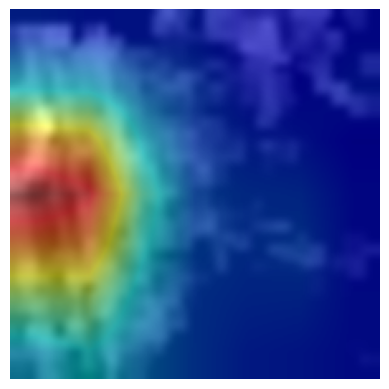

In [5]:
file = plume_list[0]
image = fe.preprocess(file)
heatmap = predict.heat_map(image, dir)
plt.imshow(heatmap)
plt.axis('off')  # Hide axis
plt.show()

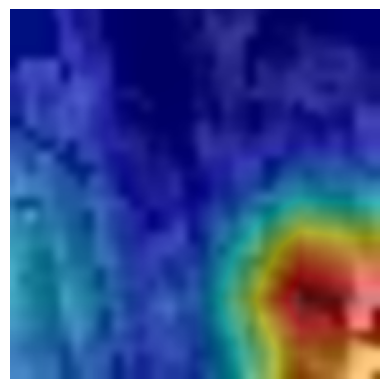

In [6]:
file = plume_list[1]
image = fe.preprocess(file)
heatmap = predict.heat_map(image, dir)
plt.imshow(heatmap)
plt.axis('off')  # Hide axis
plt.show()

# Final Success!